In [1]:
import pickle
import random
import time
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools

import SIFT

from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, confusion_matrix

# Load data from data set and set up
## Run this step before training or testing

In [2]:
plt.set_cmap('gray')

# load images
def load_images_from_folder(folder,color):
    images = {}
    for cdata in os.listdir(folder):
        # prevent to read something like .DS_store
        if cdata.startswith('.'):
            continue
        current_class = []
        path = folder + "/" + cdata
        for file in os.listdir(path):
            # prevent to read something like .DS_store
            if file.startswith('.'):
                continue
            image = cv2.imread(path + "/" + file)
            if color == 'gray':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is not None:
                current_class.append(image)
        images[cdata] = current_class
    return images


# Read from directory
train_set  = load_images_from_folder('COMP338_Assignment1_Dataset/Training',color='gray')
test_set = load_images_from_folder('COMP338_Assignment1_Dataset/Test',color='gray')
test_set_rgb = load_images_from_folder('COMP338_Assignment1_Dataset/Test',color='rgb')

<Figure size 432x288 with 0 Axes>

# Load descriptors and keypoint classified by class from .pkl files
## Run this to skip training process

In [31]:
# load descriptors by class
with open('Models/SIFT_feature/train_descriptors_by_class.pkl', 'rb') as f:
    train_des_by_class  = pickle.load(f)

# load key_points by class
with open('Models/SIFT_feature/train_keypoint_by_class.pkl', 'rb') as f:
    train_kp_by_class = pickle.load(f)

# load .pkl file of all descriptors
with open('Models/SIFT_feature/all_training_descriptors.pkl', 'rb') as f:
    train_des_list = pickle.load(f)

# load histogram of SIFT feature for training and test set
with open('Models/histograms/train_histogram.pkl', 'rb') as f:
    train_histogram = pickle.load(f)

with open('Models/histograms/test_histogram.pkl', 'rb') as f:
    test_histogram = pickle.load(f)

# load descriptors by class for test set
with open('Models/SIFT_feature/test_descriptors_by_class.pkl', 'rb') as f:
    test_des_by_class  = pickle.load(f)

# load visual words
with open('Models/visual_words.pkl', 'rb') as f:
    words = pickle.load(f)

# Training process
## Step 1: Extract SIFT Feature

In [10]:
# SIFT Features
def sift_features(images):
    sift_vectors = {}
    keypoint_vectors = {}
    all_descriptor = []
    for image_class, folder in images.items():
        features = []
        keypoint_list = []
        pbar = tqdm(folder, position=0)
        for image in pbar:
            time.sleep(.01)
            pbar.set_description(f"Processing {image_class}", refresh=True)
            # Using sift in cv2 can accelerate the feature extraction powerfully
            cv2_sift = cv2.SIFT_create(200)
            key_p, des = cv2_sift.detectAndCompute(image, None)
            # key_p, des = SIFT.computeKeypointsAndDescriptors(image)
            all_descriptor.extend(des)
            features.append(des)
            keypoint_list.append(key_p)
        sift_vectors[image_class] = features
        keypoint_vectors[image_class] = keypoint_list
    return [all_descriptor, sift_vectors, keypoint_vectors]


# Only extract first n samples
def slice_dataset(images, n):
    dic = {}
    for image_class, folder in images.items():
        folder = folder[0:n]
        dic[image_class] = folder
    return dic

In [11]:
# Extract SIFT Features from train-set
# Only use first 2 samples in developing stage
sift_train = sift_features(train_set)
# Extract SIFT Features from test-set
sift_test = sift_features(test_set)

train_des_list = sift_train[0]
train_des_by_class = sift_train[1]
train_kp_by_class = sift_train[2]

Processing keyboard: 100%|██████████| 10/10 [00:00<00:00, 52.16it/s]


### Save the SIFT feature for both training and test set

In [13]:
# transfer cv2.keypoint to dic object
def transfer_kp_list(train_kps):
    kp_list = {}
    for image_class, images in train_kps.items():
        all_image_with_kp = []
        for image in images:
            single_img = []
            for kp in image:
                if not isinstance(kp, cv2.KeyPoint):
                    return train_kps
                kp_tran = {'pt': kp.pt, 'size': kp.size}
                single_img.append(kp_tran)
            all_image_with_kp.append(single_img)
        kp_list[image_class] = all_image_with_kp
    return kp_list

train_kp_by_class = transfer_kp_list(train_kp_by_class)
test_des_by_class = sift_test[1]

In [14]:
# save numpy dict of descriptors by class
with open('Models/SIFT_feature/train_descriptors_by_class.pkl', 'wb') as f:
    pickle.dump(train_des_by_class, f)
# save dict of key_points by class
with open('Models/SIFT_feature/train_keypoint_by_class.pkl', 'wb') as f:
    pickle.dump(train_kp_by_class, f)
# save all descriptors of training set
with open('Models/SIFT_feature/all_training_descriptors.pkl', 'wb') as f:
    pickle.dump(train_des_list, f)
# save numpy dict of descriptors by class
with open('Models/SIFT_feature/test_descriptors_by_class.pkl', 'wb') as f:
    pickle.dump(test_des_by_class, f)

## Step 2: Generate dictionary

In [15]:
# Return the cluster center from kmeans algorithm
def kmeans(k, list_descriptor):
    k_means = KMeans(n_clusters = k, n_init=10)
    k_means.fit(list_descriptor)
    visual_words = k_means.cluster_centers_
    return visual_words


# Take the central points of visual words
words = kmeans(500, train_des_list)

In [30]:
with open('Models/visual_words.pkl', 'wb') as f:
    pickle.dump(words, f)

## Step 3: Represent images with generated code words

In [16]:
def find_index(features, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if i == 0:
            count = distance.euclidean(features, center[i])
        else:
            dist = distance.euclidean(features, center[i])
            if dist < count:
                ind = i
                count = dist
    return ind


def image_histogram(all_words, centers):
    dict_feature = {}
    for image_class, folder in all_words.items():
        category = []
        pbar = tqdm(folder, position=0)
        for image in pbar:
            pbar.set_description(f"Process {image_class} images")
            histogram = np.zeros(len(centers))
            for each_feature in image:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            # normalize
            histogram = histogram/sum(histogram)
            category.append(histogram)
        dict_feature[image_class] = category
    return dict_feature

print(' #### Generate histogram from training descriptors and code words ####')
train_histogram = image_histogram(train_des_by_class, words)
print(' #### Generate histogram from testing descriptors and code words ####')
test_histogram = image_histogram(test_des_by_class, words)

 #### Generate histogram from training descriptors and code words ####


Process keyboard images: 100%|██████████| 70/70 [00:22<00:00,  3.11it/s]


 #### Generate histogram from testing descriptors and code words ####


Process keyboard images: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


In [32]:
# save histogram of training feature by class
with open('Models/histograms/train_histogram.pkl', 'wb') as f:
    pickle.dump(train_histogram, f)
# save histogram of teseting feature by class
with open('Models/histograms/test_histogram.pkl', 'wb') as f:
    pickle.dump(test_histogram, f)

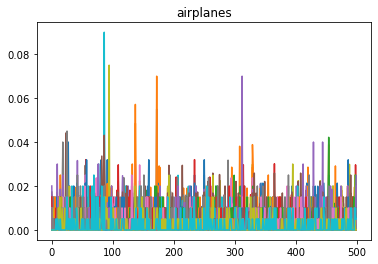

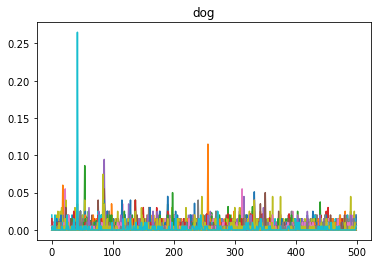

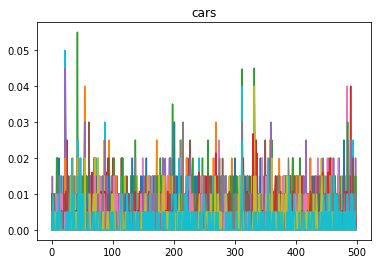

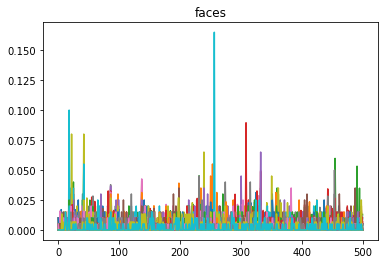

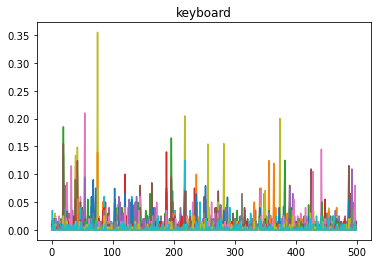

In [17]:
# Visualize the result by merging the histogram of images belonging same class
for key, value in train_histogram.items():
    plt.figure()
    plt.title(f"{key}")
    for idx, img in enumerate(value):
        plt.plot(img)

### Step 3.3 : Visualize some image patches that are assigned to the same codeword.

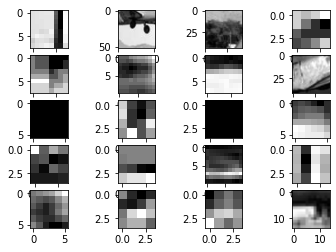

In [18]:
def plot_patches(patch_list:list):
    count = len(patch_list) # number of patch
    n_rows = int(np.ceil((count//10 + 1)*1.5)) # at least 2 row
    plt.figure()
    for patch_id, i in enumerate(patch_list):
        plt.subplot(n_rows, int(np.ceil(count/n_rows)), patch_id + 1)
        plt.imshow(i)



# input a key_point and image, then calculate the region that the key_point describe
def cut_img(kp, image):
    radius = int(np.round(kp['size']))
    pt = kp['pt']
    x = int(round(pt[0]))
    y = int(round(pt[1]))
    left = max(0, x-radius)
    high = min(len(image[0]), y + radius)
    right = min(len(image), x + radius)
    low = max(0, y-radius)
    return image[left: right, low: high]


'''
    visualize_number: an int between 0 to 20, visualize a number between 0 to 20 image patches in same code word.
    :return a list of image patches that are assigned to the same codeword.
'''
def visualize_patches(descriptors, keypoint_vectors, centers, visualize_number, dataset):
    patch_list = []

    if visualize_number > 20: visualize_number = 20

    # Random Pick a center
    sample_center = random.choice(centers)
    visual_count = 0
    for img_class, descriptor_value in descriptors.items():
        for img_idx, image in enumerate(descriptor_value):
            # similar to find_index
            for feature_idx, each_feature in enumerate(image):
                count = 0
                ind = 0
                for i in range(len(centers)):
                    if i == 0:
                        count = distance.euclidean(each_feature, centers[i])
                    else:
                        dist = distance.euclidean(each_feature, centers[i])
                        if dist < count:
                            count = dist
                            ind = i
                # check if it is equal to sample center
                if (centers[ind] == sample_center).all():
                    # get keypoint by mapping the index of descriptors
                    key_point = keypoint_vectors[img_class][img_idx][feature_idx]
                    # get img from dataset by mapping the index
                    image = dataset[img_class][img_idx]
                    img_show = cut_img(key_point, image)
                    patch_list.append(img_show)
                    visual_count += 1
                if visual_count >= visualize_number: return patch_list
    return patch_list

image_patches = visualize_patches(train_des_by_class, train_kp_by_class, words, 20, dataset=train_set)
plot_patches(image_patches)

# Inference Process
## Step 4: KNN Classification

In [19]:
def get_xy(histo):
    x = []
    y = []
    n = 0

    for image_class, images in histo.items():
        n+=1
        for image in images:
            x.append(image)
            y.append(image_class)
    return [x,y]

def to_inter(hist1, hist2):
    return cv2.compareHist(np.float32(hist1), np.float32(hist2), cv2.HISTCMP_INTERSECT)

class KnnClassifier:
    # initialize with k = 4
    def __init__(self, k=4, dis_type='L2'):
        self.key = k
        self.dis_type = dis_type
        self.xtr, self.ytr = None, None

    def fit(self, xtr, ytr):
        self.xtr = xtr
        self.ytr = ytr

    # to predict the digits
    def predict(self, x_test1):
        num = len(x_test1)
        y_predict = list(range(len(x_test1)))
        for i in range(num):
            # Calculate the distance based on p, p = 1 Manhattan, p = 2 euclidean distance
            distances = []
            for image_class_, z in enumerate(self.xtr):
                if self.dis_type != 'L2':
                    d = to_inter(z, x_test1[i])
                else:
                    d = distance.euclidean(z, x_test1[i])
                distances.append(d)
            distances = np.array(distances)
            if self.dis_type == 'L2':
                # Sort and get the index of first key distance
                sorted_distances = np.argsort(distances)[:self.key]
            if self.dis_type == 'inter':
                sorted_distances = np.argsort(distances)[::-1]
                sorted_distances = sorted_distances[:self.key]
            # Accumulate the count for each possible prediction label
            accumulate = np.zeros(len(np.unique(self.ytr)))
            classes = np.unique(self.ytr)
            for z in sorted_distances:
                # ytr[z] = the prediction result for one result corresponding k_value
                class_index = np.where(classes == self.ytr[z])[0][0]
                accumulate[class_index] += 1
            # Check the index of the most possible prediction, index = the prediction result
            y_predict[i] = classes[np.argmax(accumulate)]
        return np.array(y_predict)

In [20]:
# Giving labels to train set and test set
train_x, train_y = get_xy(train_histogram)
test_x, test_y = get_xy(test_histogram)

l2_knn = KnnClassifier(k=1, dis_type='L2')
l2_knn.fit(train_x, train_y)
predict_y_l2 = l2_knn.predict(test_x)

predict_y_l2

array(['dog', 'cars', 'cars', 'faces', 'cars', 'cars', 'cars', 'dog',
       'airplanes', 'dog', 'airplanes', 'cars', 'dog', 'dog', 'dog',
       'faces', 'airplanes', 'cars', 'cars', 'airplanes', 'cars', 'cars',
       'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'keyboard', 'cars', 'cars', 'faces', 'dog', 'faces', 'dog',
       'cars', 'faces', 'airplanes', 'airplanes', 'keyboard', 'faces',
       'keyboard', 'cars', 'keyboard', 'faces', 'faces', 'faces'],
      dtype='<U9')

# Step 5: Evaluation

In [22]:
def divide_into_correct_and_incorrect(key, test, predict_y):
    correct = {}
    incorrect = {}
    for i in range(len(key)):
        class_correct = []
        class_incorrect = []
        for j in range(len(predict_y_l2)):
            if predict_y[j] == key[i] or test[j] == key[i]:
                if test[j] == predict_y[j]:
                    class_correct.append(j)
                else:
                    if test[j] == key[i]:
                        class_incorrect.append(j)
        correct[key[i]] = class_correct
        incorrect[key[i]] = class_incorrect
    return correct, incorrect

correct_l2, incorrect_l2 = divide_into_correct_and_incorrect(list(test_set.keys()),test_y, predict_y_l2)


l2_score = accuracy_score(test_y, predict_y_l2)
print(f"The average of predication based on L2 KNN for all classes is {l2_score}")

for key, value in correct_l2.items():
    print(f"The average of predication based on L2 KNN for class {key} is {len(value)/len(test_set[key])}")

The average of predication based on L2 KNN for all classes is 0.4
The average of predication based on L2 KNN for class airplanes is 0.1
The average of predication based on L2 KNN for class dog is 0.3
The average of predication based on L2 KNN for class cars is 1.0
The average of predication based on L2 KNN for class faces is 0.3
The average of predication based on L2 KNN for class keyboard is 0.3
The average of predication based on L2 KNN for all classes is 0.4
The average of predication based on L2 KNN for class airplanes is 0.1
The average of predication based on L2 KNN for class dog is 0.3
The average of predication based on L2 KNN for class cars is 1.0
The average of predication based on L2 KNN for class faces is 0.3
The average of predication based on L2 KNN for class keyboard is 0.3


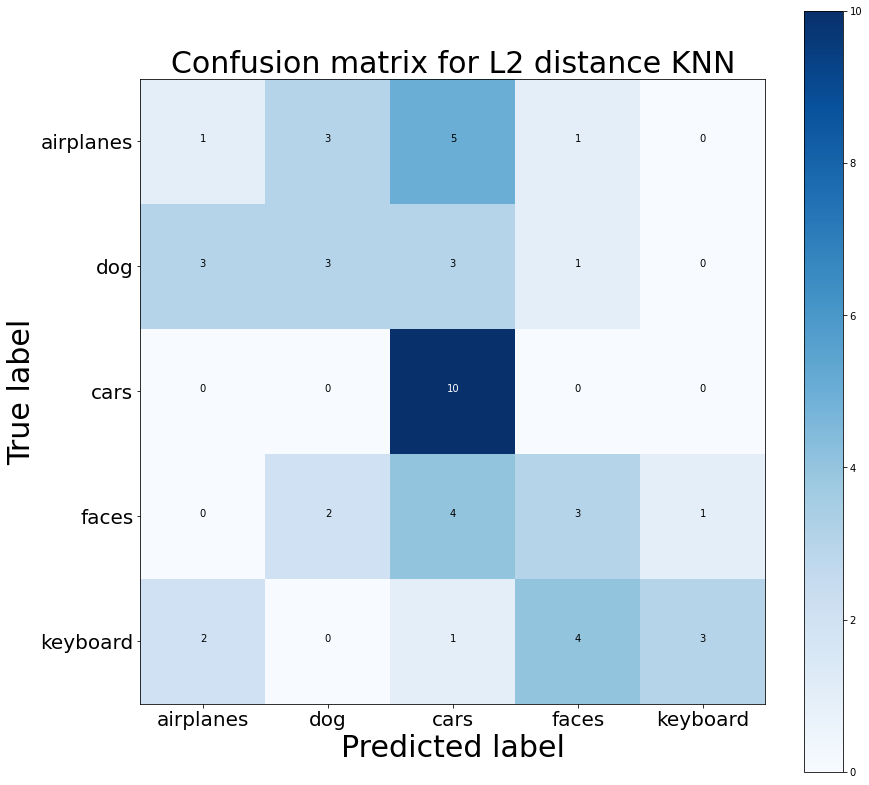

In [23]:
def draw_confusion_matrix(cm, title, classes):
    # Confusion matrix graph
    plt.figure(figsize=(14, 14))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.ylim(-0.5, 4.5)
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    plt.gca().invert_yaxis()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.show()

# Calculate Confusion Matrix
cm_l2 = confusion_matrix(test_y, predict_y_l2, labels=list(test_histogram.keys()))
draw_confusion_matrix(cm_l2, 'Confusion matrix for L2 distance KNN', list(test_histogram.keys()))

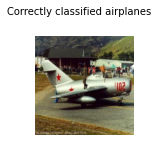

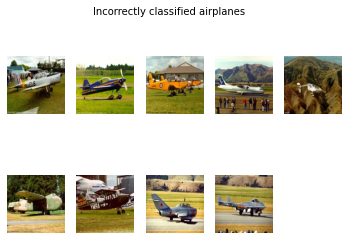

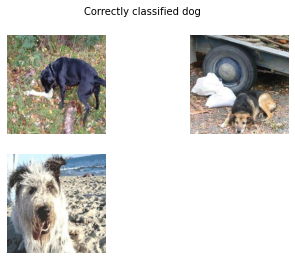

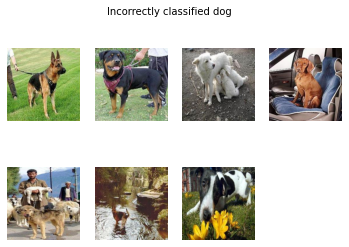

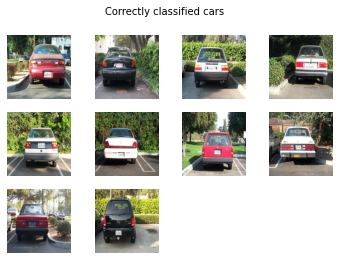

<Figure size 432x288 with 0 Axes>

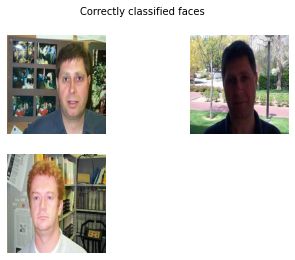

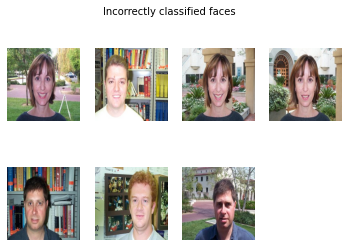

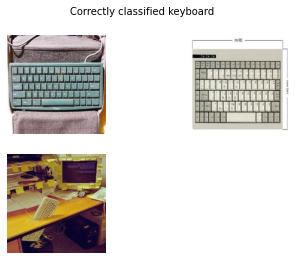

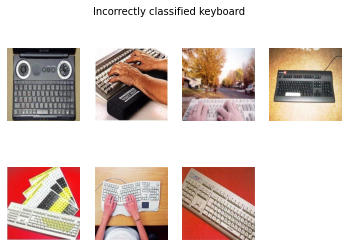

In [24]:
def plot_correct(patch_list:list, title):
    count = len(patch_list) # number of patch
    n_rows = int(np.ceil((count//10 + 1)*1.5)) # at least 2 row
    plt.figure()
    plt.suptitle(title, fontsize=10)
    for patch_id, i in enumerate(patch_list):
        plt.subplot(n_rows, int(np.ceil(count/n_rows)), patch_id + 1)
        plt.imshow(i)
        plt.axis('off')
    plt.show()


def show_classified(dataset, correct , incorrect, test_y):
    all_pic = []

    for k in dataset.keys():
        for i in dataset[k]:
            all_pic.append(i)

    for k in list(dataset.keys()):
        p_correct = correct[k]
        p_incorrect = incorrect[k]
        correct_pic = []
        incorrect_pic = []
        for c in p_correct:
            correct_pic.append(all_pic[c])
        plot_correct(correct_pic, f"Correctly classified {k}")

        for i_c in p_incorrect:
            incorrect_pic.append(all_pic[i_c])
        plot_correct(incorrect_pic, f"Incorrectly classified {k}")

show_classified(test_set_rgb, correct_l2, incorrect_l2, test_y)

# Step 6: Replace the L2 distances with the histogram intersection

--------------------------------------
The average of predication based on Histogram Intersection KNN for all classes is 0.5
The average of predication based on Histogram Intersection KNN for class airplanes is 0.1
The average of predication based on Histogram Intersection KNN for class dog is 0.3
The average of predication based on Histogram Intersection KNN for class cars is 1.0
The average of predication based on Histogram Intersection KNN for class faces is 0.3
The average of predication based on Histogram Intersection KNN for class keyboard is 0.3


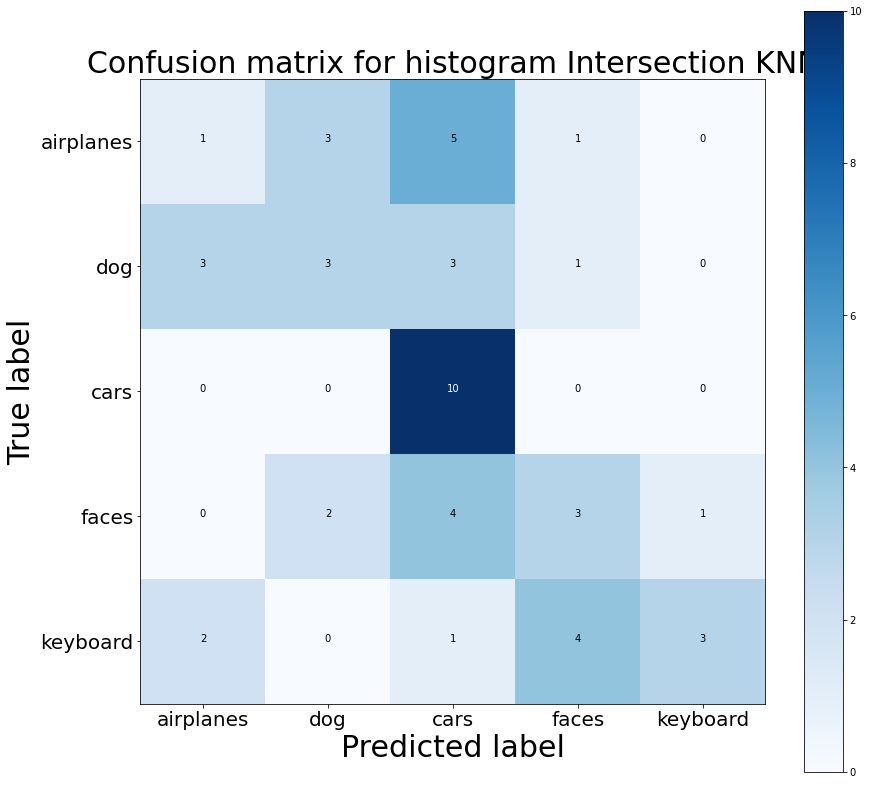

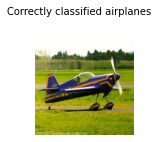

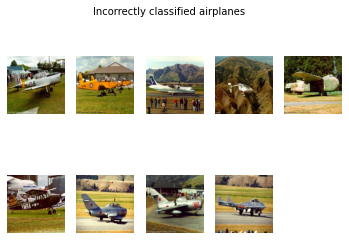

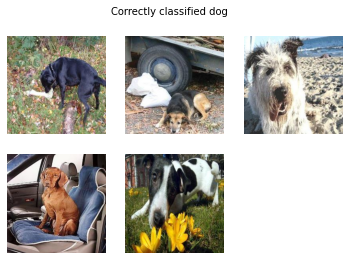

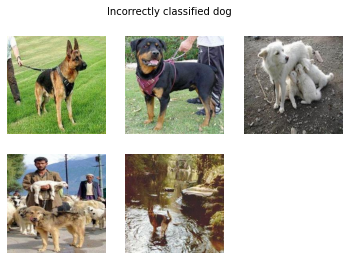

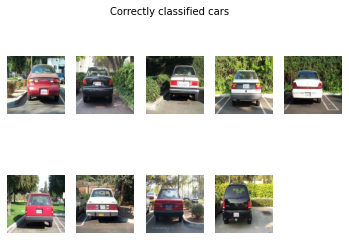

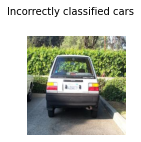

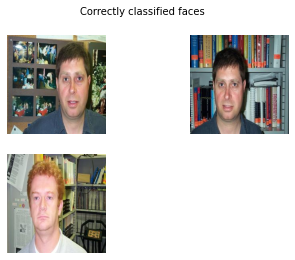

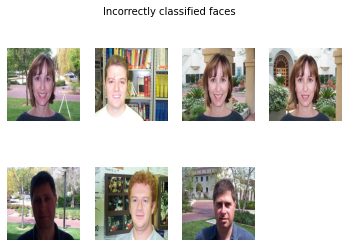

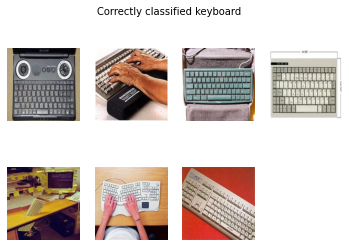

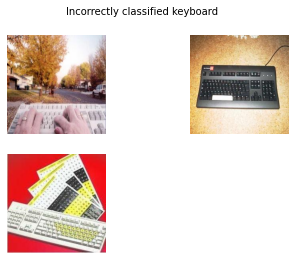

In [25]:
# Perform KNN by histogram intersection
knn = KnnClassifier(k=1, dis_type='inter')
knn.fit(train_x, train_y)
predict_y_inter = knn.predict(test_x)

# Calculate accuracy
print('--------------------------------------')
inter_score = accuracy_score(test_y, predict_y_inter)
print(f"The average of predication based on Histogram Intersection KNN for all classes is {inter_score}")
for key, value in correct_l2.items():
    print(f"The average of predication based on Histogram Intersection KNN for class {key} is {len(value)/len(test_set[key])}")

# Calculate Confusion matrix
cm_inter = confusion_matrix(test_y, predict_y_inter, labels=list(test_histogram.keys()))
draw_confusion_matrix(cm_l2, 'Confusion matrix for histogram Intersection KNN', list(test_histogram.keys()))

correct_inter, incorrect_inter = divide_into_correct_and_incorrect(list(test_set.keys()),test_y, predict_y_inter)
show_classified(test_set_rgb, correct_inter, incorrect_inter, test_y)

# Step 7: Replace 500 code words with the 20 code words

In [26]:
words_small = kmeans(20, train_des_list)

print(' #### Generate histogram from training descriptors and 20 code words ####')
train_histogram_small = image_histogram(train_des_by_class, words)
print(' #### Generate histogram from testing descriptors and 20 code words ####')
test_histogram_small = image_histogram(test_des_by_class, words)


 #### Generate histogram from training descriptors and 20 code words ####


Process keyboard images: 100%|██████████| 70/70 [00:22<00:00,  3.15it/s]


 #### Generate histogram from testing descriptors and 20 code words ####


Process keyboard images: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


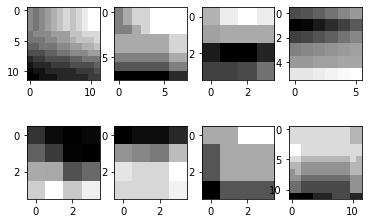

In [27]:
image_patches_small = visualize_patches(train_des_by_class, train_kp_by_class, words_small, 8, dataset=train_set)
plot_patches(image_patches_small)

In [28]:
train_x_small, train_y_small = get_xy(train_histogram_small)
test_x_small, test_y_small = get_xy(test_histogram_small)
l2_knn_small = KnnClassifier(k=1, dis_type='L2')
l2_knn_small.fit(train_x_small, train_y_small)
predict_y_l2_small = l2_knn_small.predict(test_x_small)
correct_l2_small, incorrect_l2_small = divide_into_correct_and_incorrect(list(test_set.keys()),test_y_small, predict_y_l2_small)

print('--------------------------------------')
l2_score_small = accuracy_score(test_y_small, predict_y_l2_small)
print(f"The average of predication based on L2 KNN and 20 code words for all classes is {l2_score_small}")
for key, value in correct_l2_small.items():
    print(f"The average of predication based on L2 KNN and 20 code words for class {key} is {len(value)/len(test_set[key])}")


--------------------------------------
The average of predication based on L2 KNN and 20 code words for all classes is 0.4
The average of predication based on L2 KNN and 20 code words for class airplanes is 0.1
The average of predication based on L2 KNN and 20 code words for class dog is 0.3
The average of predication based on L2 KNN and 20 code words for class cars is 1.0
The average of predication based on L2 KNN and 20 code words for class faces is 0.3
The average of predication based on L2 KNN and 20 code words for class keyboard is 0.3


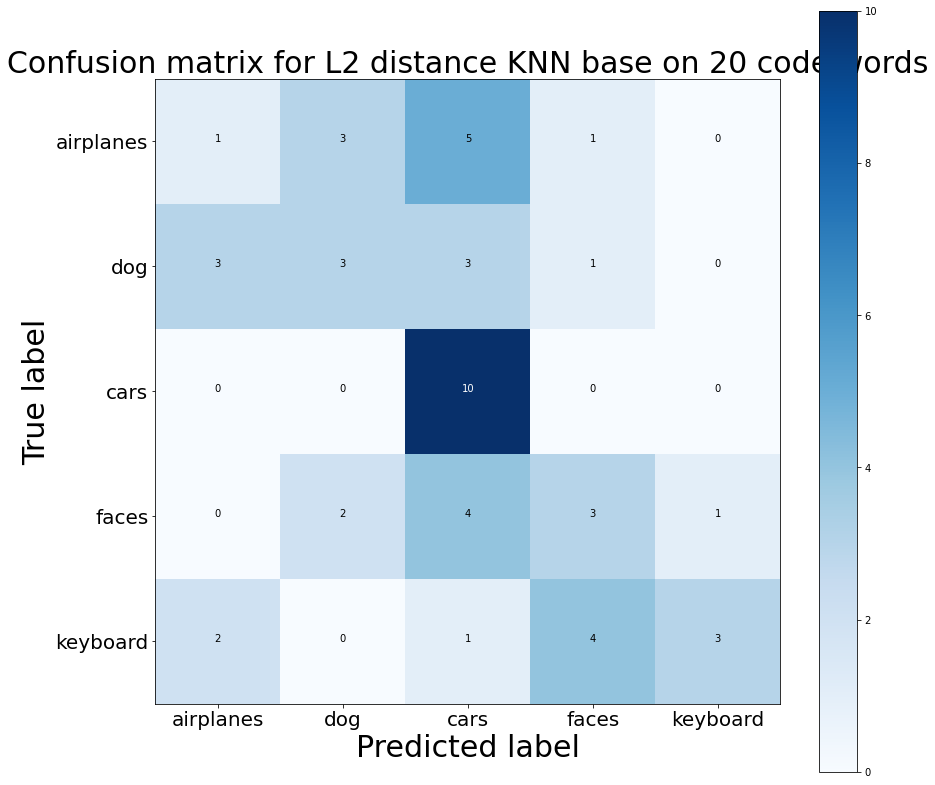

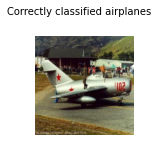

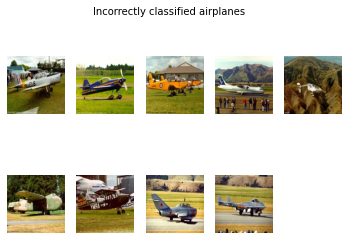

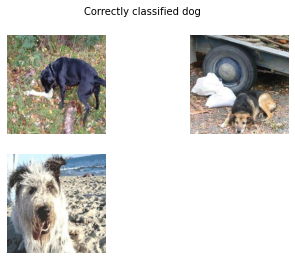

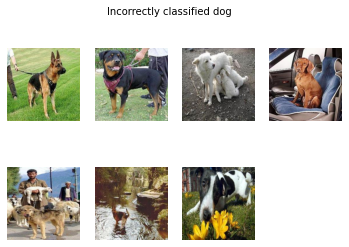

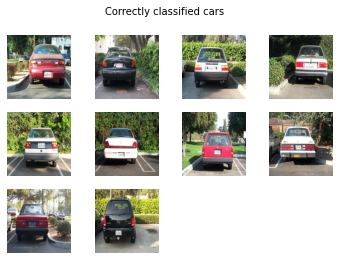

<Figure size 432x288 with 0 Axes>

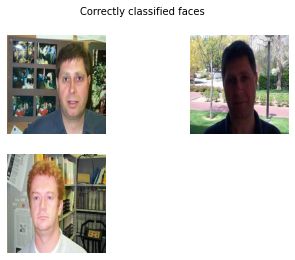

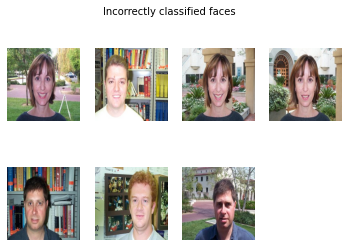

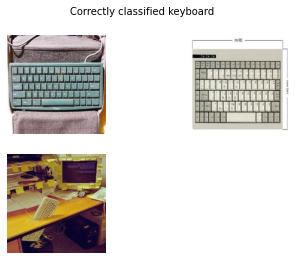

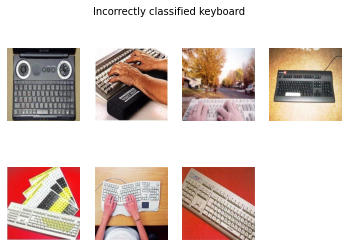

In [29]:
# Calculate Confusion matrix
cm_l2_small = confusion_matrix(test_y_small, predict_y_l2_small, labels=list(test_histogram_small.keys()))
draw_confusion_matrix(cm_l2_small, 'Confusion matrix for L2 distance KNN base on 20 code words', list(test_histogram_small.keys()))

show_classified(test_set_rgb, correct_l2_small, incorrect_l2_small, test_y_small)